In [2]:
! pip install linearmodels

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.0/91.0 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 4.4 MB/s eta 0:00:00


In [13]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import style
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
import graphviz as gr
from linearmodels.iv import IV2SLS
import os

%matplotlib inline

pd.set_option("display.max_columns", 5)


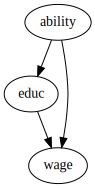

In [4]:
g = gr.Digraph()

g.edge("ability", "educ")
g.edge("ability", "wage")
g.edge("educ", "wage")
g

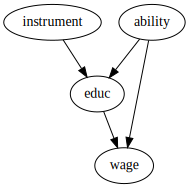

In [5]:
g = gr.Digraph()

g.edge("ability", "educ")
g.edge("ability", "wage")
g.edge("educ", "wage")
g.edge("instrument", "educ")
g

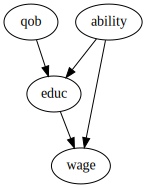

In [6]:
g = gr.Digraph()

g.edge("ability", "educ")
g.edge("ability", "wage")
g.edge("educ", "wage")
g.edge("qob", "educ")
g

In [16]:
os.chdir('/content/drive/MyDrive/DSLab/Stat101/04 casual inference/02 notebook')


data = pd.read_csv("../01 data/ak91.csv")
data.head()

,log_wage,years_of_schooling,year_of_birth,quarter_of_birth,state_of_birth
0,5.790019,12.0,30.0,1.0,45.0
1,5.952494,11.0,30.0,1.0,45.0
2,5.315949,12.0,30.0,1.0,45.0
3,5.595926,12.0,30.0,1.0,45.0
4,6.068915,12.0,30.0,1.0,37.0


In [17]:
group_data = (data
              .groupby(["year_of_birth", "quarter_of_birth"])
              [["log_wage", "years_of_schooling"]]
              .mean()
              .reset_index()
              .assign(time_of_birth = lambda d: d["year_of_birth"] + (d["quarter_of_birth"])/4))

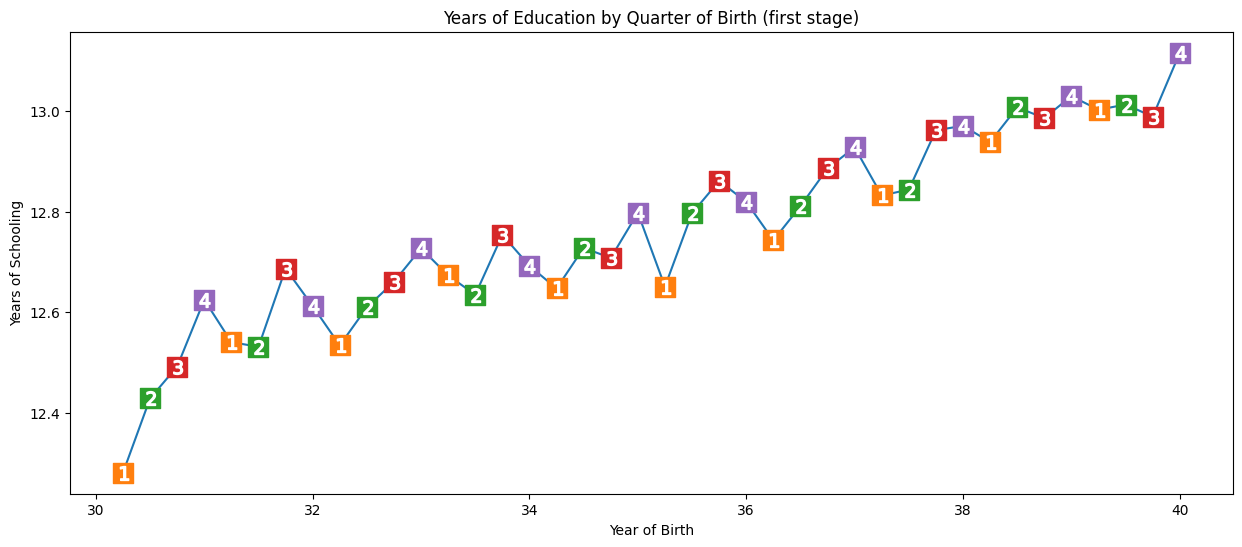

In [18]:
plt.figure(figsize=(15,6))
plt.plot(group_data["time_of_birth"], group_data["years_of_schooling"], zorder=-1)
for q in range(1, 5):
    x = group_data.query(f"quarter_of_birth=={q}")["time_of_birth"]
    y = group_data.query(f"quarter_of_birth=={q}")["years_of_schooling"]
    plt.scatter(x, y, marker="s", s=200, c=f"C{q}")
    plt.scatter(x, y, marker=f"${q}$", s=100, c=f"white")

plt.title("Years of Education by Quarter of Birth (first stage)")
plt.xlabel("Year of Birth")
plt.ylabel("Years of Schooling");

In [19]:
factor_data = data.assign(**{f"q{int(q)}": (data["quarter_of_birth"] == q).astype(int)
                             for q in data["quarter_of_birth"].unique()})

factor_data.head()

,log_wage,years_of_schooling,...,q3,q4
0,5.790019,12.0,...,0,0
1,5.952494,11.0,...,0,0
2,5.315949,12.0,...,0,0
3,5.595926,12.0,...,0,0
4,6.068915,12.0,...,0,0


In [20]:
first_stage = smf.ols("years_of_schooling ~ C(year_of_birth) + C(state_of_birth) + q4", data=factor_data).fit()

print("q4 parameter estimate:, ", first_stage.params["q4"])
print("q4 p-value:, ", first_stage.pvalues["q4"])

q4 parameter estimate:,  0.10085809272787055
q4 p-value:,  5.464829416599837e-15


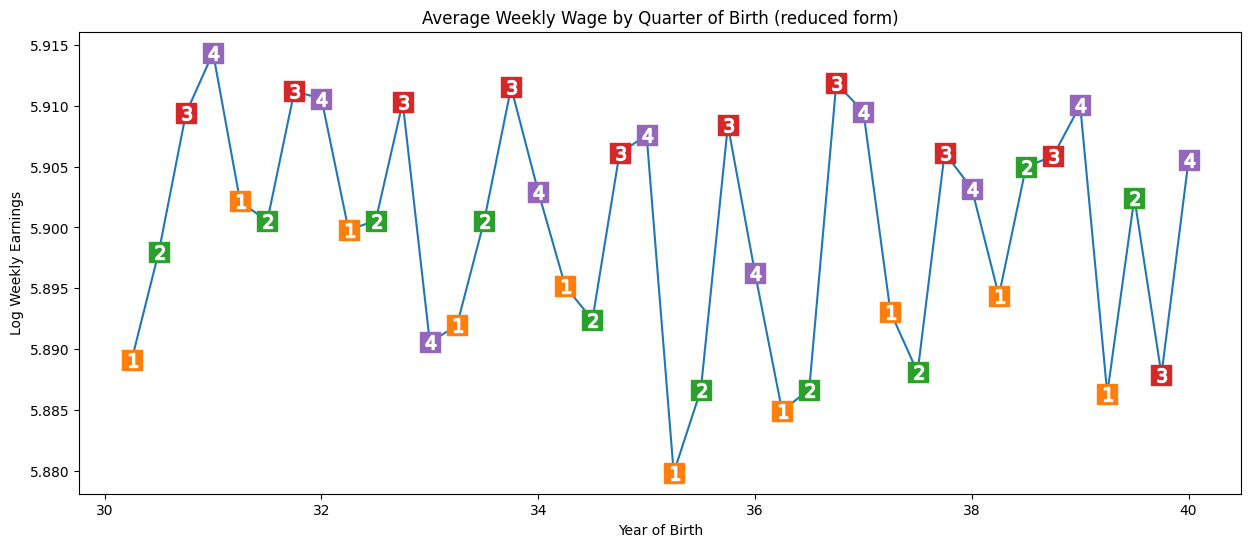

In [21]:
plt.figure(figsize=(15,6))
plt.plot(group_data["time_of_birth"], group_data["log_wage"], zorder=-1)
for q in range(1, 5):
    x = group_data.query(f"quarter_of_birth=={q}")["time_of_birth"]
    y = group_data.query(f"quarter_of_birth=={q}")["log_wage"]
    plt.scatter(x, y, marker="s", s=200, c=f"C{q}")
    plt.scatter(x, y, marker=f"${q}$", s=100, c=f"white")

plt.title("Average Weekly Wage by Quarter of Birth (reduced form)")
plt.xlabel("Year of Birth")
plt.ylabel("Log Weekly Earnings");

In [22]:
reduced_form = smf.ols("log_wage ~ C(year_of_birth) + C(state_of_birth) + q4", data=factor_data).fit()

print("q4 parameter estimate:, ", reduced_form.params["q4"])
print("q4 p-value:, ", reduced_form.pvalues["q4"])

q4 parameter estimate:,  0.008603484260141542
q4 p-value:,  0.001494912718363033


### Instrumental Variables by Hand

In [23]:
reduced_form.params["q4"] / first_stage.params["q4"]

0.08530286492086424

This means that we should expect each additional year of school to increase wages by 8%.

In [25]:
def parse(model, exog="years_of_schooling"):
    param = model.params[exog]
    se = model.std_errors[exog]
    p_val = model.pvalues[exog]
    print(f"Parameter: {param}")
    print(f"SE: {se}")
    print(f"95 CI: {(-1.96*se,1.96*se) + param}")
    print(f"P-value: {p_val}")

formula = 'log_wage ~ 1 + C(year_of_birth) + C(state_of_birth) + [years_of_schooling ~ q4]'
iv2sls = IV2SLS.from_formula(formula, factor_data).fit()
parse(iv2sls)

Parameter: 0.08530286491936041
SE: 0.02554081281155219
95 CI: [0.03524287 0.13536286]
P-value: 0.0008381914653607936


### Multiple Instruments

In [26]:
formula = 'log_wage ~ 1 + C(year_of_birth) + C(state_of_birth) + [years_of_schooling ~ q1+q2+q3]'
iv_many_zs = IV2SLS.from_formula(formula, factor_data).fit()
parse(iv_many_zs)

Parameter: 0.10769370489195511
SE: 0.01955714901026733
95 CI: [0.06936169 0.14602572]
P-value: 3.657974678716869e-08


##### To compare, normal linear regression

In [27]:
formula = "log_wage ~ years_of_schooling + C(state_of_birth) + C(year_of_birth) + C(quarter_of_birth)"
ols = IV2SLS.from_formula(formula, data=data).fit()
parse(ols)

Parameter: 0.06732572817658244
SE: 0.0003883998439048624
95 CI: [0.06656446 0.06808699]
P-value: 0.0


## explore stand err

In [28]:
np.random.seed(12)
n = 10000
X = np.random.normal(0, 2, n) # observable variable
U = np.random.normal(0, 2, n) # unobservable (omitted) variable
T = np.random.normal(1 + 0.5*U, 5, n) # treatment
Y = np.random.normal(2 + X - 0.5*U + 2*T, 5, n) # outcome

stddevs = np.linspace(0.1, 100, 50)
Zs = {f"Z_{z}": np.random.normal(T, s, n) for z, s in enumerate(stddevs)} # instruments with decreasing \mathrm{Cov}(Z, T)

sim_data = pd.DataFrame(dict(U=U, T=T, Y=Y)).assign(**Zs)

sim_data.head()

,U,T,...,Z_48,Z_49
0,2.696148,8.056988,...,-117.798705,-13.485292
1,2.570240,0.245067,...,-209.727577,-70.792948
2,0.664741,5.597510,...,60.562232,47.619414
3,1.037725,0.493532,...,78.136513,-108.322304
4,-2.590591,-6.263014,...,78.776566,-80.547214


In [29]:
corr = (sim_data.corr()["T"]
        [lambda d: d.index.str.startswith("Z")])

corr.head()

Z_0    0.999807
Z_1    0.919713
Z_2    0.773434
Z_3    0.634614
Z_4    0.523719
Name: T, dtype: float64

In [30]:
se = []
ate = []
for z in range(len(Zs)):
    formula = f'Y ~ 1 + X + [T ~ Z_{z}]'
    iv = IV2SLS.from_formula(formula, sim_data).fit()
    se.append(iv.std_errors["T"])
    ate.append(iv.params["T"])

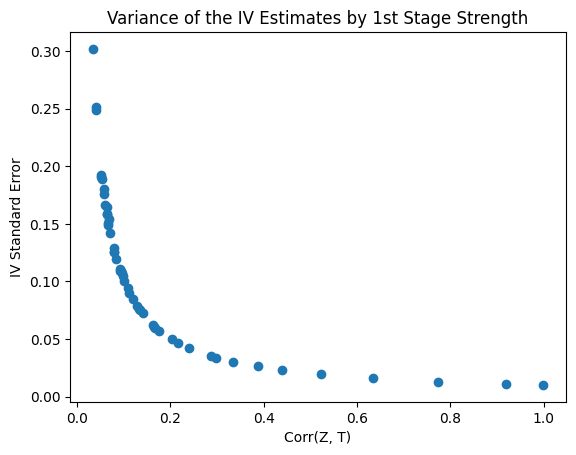

In [31]:
plot_data = pd.DataFrame(dict(se=se, ate=ate, corr=corr)).sort_values(by="corr")

plt.scatter(plot_data["corr"], plot_data["se"])
plt.xlabel("Corr(Z, T)")
plt.ylabel("IV Standard Error");
plt.title("Variance of the IV Estimates by 1st Stage Strength");

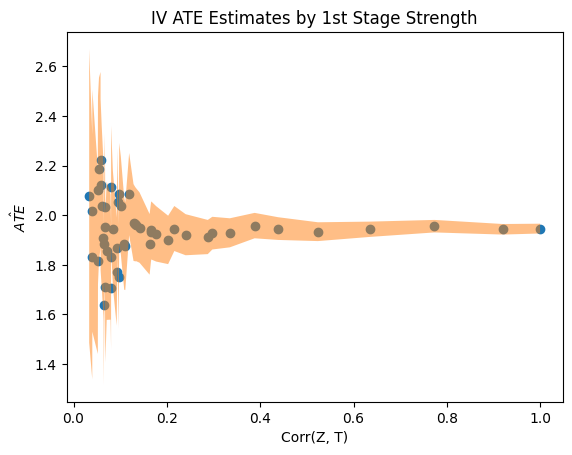

In [32]:
plt.scatter(plot_data["corr"], plot_data["ate"])
plt.fill_between(plot_data["corr"],
                 plot_data["ate"]+1.96*plot_data["se"],
                 plot_data["ate"]-1.96*plot_data["se"], alpha=.5)
plt.xlabel("Corr(Z, T)")
plt.ylabel("$\hat{ATE}$");
plt.title("IV ATE Estimates by 1st Stage Strength");